In [1]:
# Joachim DAVID december 2018
# Ghent University
# Zwijnaarde Industriepark 15
# 9000 Gent
# Joachim.David@UGent.be
#############################

# REFERENCES:
# http://reliawiki.org/index.php/The_Exponential_Distribution
# http://reliawiki.org/index.php/The_Weibull_Distribution
# @book{verma2010reliability,
#   title={Reliability and safety engineering},
#   author={Verma, Ajit Kumar and Ajit, Srividya and Karanki, Durga Rao},
#   volume={43},
#   chapter={2}
#   year={2010},
#   publisher={Springer}
# }
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import sys
sys.path.append('..')

%load_ext autoreload
%autoreload 2

#import matplotlib
#matplotlib.matplotlib_fname()

In [2]:
filename = 'productionfile.csv' # 'packagingfile.csv'
df = pd.read_csv(filename, parse_dates=['StartDateUTC', 'EndDateUTC'])
df = df.sort_values('StartDateUTC')
list_reasons = list(df.ReasonId.unique())
list_reasons.sort()
print(list_reasons)

[0, 1, 2, 3, 5, 7, 8, 9, 10, 11]


In [5]:
# VARIABLES
cutoff_perc = 100
dtcutoff_perc = 100
reasons_considered = reasons_relative = [7, 8]
reasons_to_ignore = [0, 1, 2, 3, 5, 9, 10, 11]
reasons_to_break = []
sorted_reasons = reasons_considered + reasons_to_ignore + reasons_to_break
assert(set(list_reasons) == set(sorted_reasons))

In [4]:
df.ArticleName = df.ArticleName.str.upper()
df

,EquipmentId,ProductionRequestId,SegmentResponseId,StartDateUTC,EndDateUTC,Duration,ReasonId,IgnoreType,ArticleCode,ArticleName,Type,Quantity
0,50,50675.0,74525.0,2016-01-19 14:21:47.980,2016-01-19 14:22:51.830,64.000,10,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000
1,50,50675.0,74525.0,2016-01-19 14:22:51.830,2016-01-19 17:23:51.660,10860.000,1,0,FF029001,MACARONI KORT PLATTE ZAK,RunTime,30000
2,50,50675.0,74525.0,2016-01-19 17:23:51.660,2016-01-19 17:30:45.690,414.000,8,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000
3,50,50675.0,74525.0,2016-01-19 17:30:45.690,2016-01-19 19:41:56.830,7871.000,1,0,FF029001,MACARONI KORT PLATTE ZAK,RunTime,30000
4,50,50675.0,74525.0,2016-01-19 19:41:56.830,2016-01-19 19:44:53.073,177.000,10,0,FF029001,MACARONI KORT PLATTE ZAK,DownTime,30000
5,50,50675.0,74525.0,2016-01-19 19:44:53.073,2016-01-19 19:49:18.047,265.000,1,0,FF029001,MACARONI KORT PLATTE ZAK,RunTime,30000
6,0,0.0,0.0,2016-01-19 19:49:18.047,2016-01-21 09:56:44.780,137246.733,0,0,000000EU,NONE,Break,0
7,50,50724.0,74711.0,2016-01-21 09:56:44.780,2016-01-21 09:58:50.930,126.000,9,0,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,30000
8,50,50724.0,74711.0,2016-01-21 09:58:50.930,2016-01-21 10:51:08.090,3138.000,1,0,FF011501,"GESNEDEN MACARONI AS 0,9%",RunTime,30000
9,50,50724.0,74711.0,2016-01-21 10:51:08.090,2016-01-21 10:56:02.120,294.000,8,0,FF011501,"GESNEDEN MACARONI AS 0,9%",DownTime,30000


### Statistics

In [5]:
df.groupby(['ReasonId', 'Type']).agg({'Duration': 'sum'})

Duration
ReasonId Type                  
0        Break     1.123825e+07
1        DownTime  4.365920e+05
         RunTime   3.711478e+07
2        DownTime  2.658000e+03
3        DownTime  2.712250e+05
5        DownTime  2.409185e+06
7        DownTime  1.598534e+06
8        DownTime  3.726380e+05
9        DownTime  5.050800e+05
10       DownTime  1.235217e+06
11       DownTime  3.640564e+06

Text(-1,0.5,'t[s]')

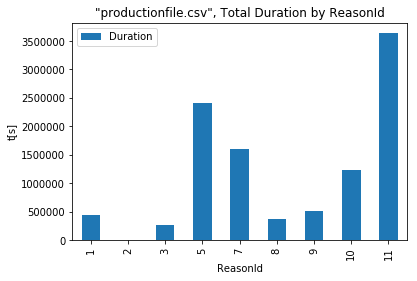

In [6]:
# Show a plot of the downtime per reason
df[df['Type']=='DownTime'].groupby(['ReasonId']).agg({'Duration': 'sum'}).plot.bar(subplots=True)
plt.title('"{}", Total Duration by ReasonId'.format(filename))
plt.savefig('D:/temp/overview.png', dpi=300, bbox_inches='tight')
plt.ylabel('t[s]')

# Downtime probability

In [7]:
from probdist import duration_between_downtime
bool_up = (df.Type == 'RunTime') # List of all RunTimes
bool_down = (df.Type.isin(['DownTime', 'Break'])) & (df.ReasonId.isin(reasons_considered)) # List of all DownTimes in calculation
bool_ignore = (df.Type.isin(['DownTime', 'Break'])) & (df.ReasonId.isin(reasons_to_ignore)) # List of all breaks to ignore
bool_break = (df.Type.isin(['DownTime', 'Break'])) & (df.ReasonId.isin(reasons_to_break)) # List of all breaks to stop observation
# Will ignore types of DownTimes not in the list
#duration = duration_between_downtime(list(df.Duration), list(bool_up), list(bool_down))
#duration.head()
#len(duration)
assert(bool((bool_up ^ bool_down ^ bool_ignore ^ bool_break).unique()) == True)

In [8]:
# duration = duration / 3600 # go to hours
# duration.head()

In [9]:
# from probdist import duration_of_downtime
# downtimes = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered))
# dtduration = duration_of_downtime(list(df.Duration), list(bool_up), list(bool_down)) / 3600
# len(dtduration)
# dtduration.head()

In [10]:
from probdist import duration_run_down
runtime, downtime, obs_run, obs_down = duration_run_down(list(df.Duration / 3600), list(bool_up), list(bool_down),
                                                           list(bool_ignore), list(bool_break), observation=True)
len(runtime), len(downtime), len(obs_run), len(obs_down)

(817, 817, 817, 817)

In [11]:
obs_down.head()

0    True
1    True
2    True
3    True
4    True
dtype: bool

In [12]:
dt = pd.DataFrame([runtime, obs_run], index=['Times', 'Observed']).T
dt.to_excel(filename.split('.')[0] + '_runtimes.xls', index=False)
print(dt.groupby('Observed').count())

          Times
Observed       
1.0         817


In [13]:
dt = pd.DataFrame([downtime, obs_down], index=['Times', 'Observed']).T
dt.to_excel(filename.split('.')[0] + '_downtimes.xls', index=False)
print(dt.groupby('Observed').count())

          Times
Observed       
1.0         817


## Some measures in practice

In [14]:
# mean hourly failure rate
# MLE = len(runtime)/np.sum(runtime)

In [15]:
# print('List of reasons considered:', reasons_considered)
# # Mean time between failures MTBF
# MTBF_pract = 1/MLE
# print('Mean Time Between Failures {:.3} hours'.format(MTBF_pract))
# #lamb = MLE
# #print('Lambda: {:.3e} /hour'.format(lamb))

### Fit using Kaplan-Meier (piecewise)

In [16]:
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

In [17]:
kmf.fit(runtime, event_observed=obs_run)

<lifelines.KaplanMeierFitter: fitted with 817 observations, 0 censored>

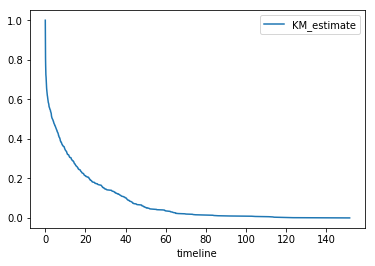

In [18]:
kmf.survival_function_.plot()

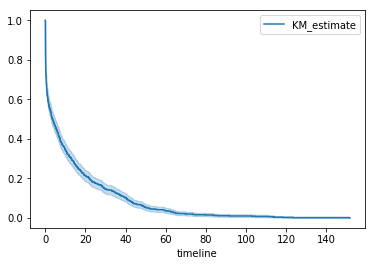

In [19]:
kmf.plot(show_censors=True, censor_styles={'ms': 2, 'marker': 'o'})

<lifelines.WeibullFitter: fitted with 817 observations, 0 censored>
number of subjects = 817
  number of events = 817
    log-likelihood = -2426.577
        hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda_  6.53      0.50        5.55        7.51 <0.005     92.06
rho_     0.48      0.01        0.45        0.51 <0.005       inf


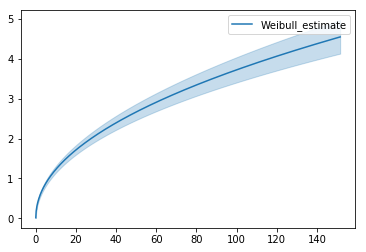

In [20]:
from lifelines import WeibullFitter
wf = WeibullFitter().fit(runtime, event_observed=obs_run)

wf.print_summary()
wf.plot()

In [21]:
# dir(wf)

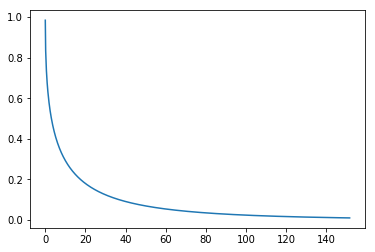

In [22]:
plt.plot(wf.survival_function_)

<lifelines.WeibullFitter: fitted with 817 observations, 0 censored>
number of subjects = 817
  number of events = 817
    log-likelihood = -2426.577
        hypothesis = lambda_ != 1, rho_ != 1

---
         coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
lambda_  6.53      0.50        5.55        7.51 <0.005     92.06
rho_     0.48      0.01        0.45        0.51 <0.005       inf
<lifelines.ExponentialFitter: fitted with 817 observations, 0 censored>
number of subjects = 817
  number of events = 817
    log-likelihood = -2888.241
        hypothesis = lambda_ != 1

---
         coef  se(coef)  lower 0.95  upper 0.95    p  -log2(p)
lambda_ 12.62     28.58      -43.40       68.64 0.68      0.55
<lifelines.LogNormalFitter: fitted with 817 observations, 0 censored>
number of subjects = 817
  number of events = 817
    log-likelihood = -2474.423
        hypothesis = mu_ != 0, sigma_ != 1

---
        coef  se(coef)  lower 0.95  upper 0.95      p  -log2(p)
mu_     0.65      0.09   

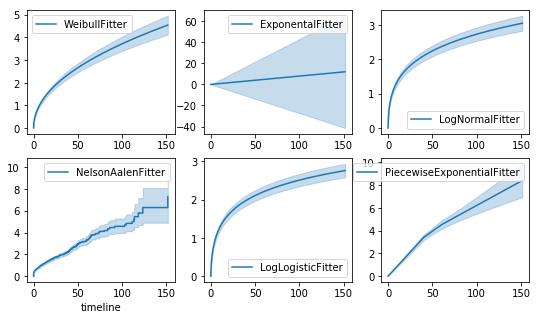

In [23]:
from lifelines import WeibullFitter, ExponentialFitter, LogNormalFitter, NelsonAalenFitter, LogLogisticFitter, PiecewiseExponentialFitter
wbf = WeibullFitter().fit(runtime, obs_run, label='WeibullFitter')
wbf.print_summary()
exf = ExponentialFitter().fit(runtime, obs_run, label='ExponentalFitter')
exf.print_summary()
lnf = LogNormalFitter().fit(runtime, obs_run, label='LogNormalFitter')
lnf.print_summary()
naf = NelsonAalenFitter().fit(runtime, obs_run, label='NelsonAalenFitter')
#naf.print_summary()
llf = LogLogisticFitter().fit(runtime, obs_run, label='LogLogisticFitter')
llf.print_summary()
pwf = PiecewiseExponentialFitter([40, 60]).fit(runtime, obs_run, label='PiecewiseExponentialFitter')
pwf.print_summary()

fig, axes = plt.subplots(2, 3, figsize=(9, 5))



wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
naf.plot_cumulative_hazard(ax=axes[1][0])
llf.plot_cumulative_hazard(ax=axes[1][1])
pwf.plot_cumulative_hazard(ax=axes[1][2])

This is a Weibull distribution with alpha 13.8 and beta 0.816
This results in a decreasing failure rate


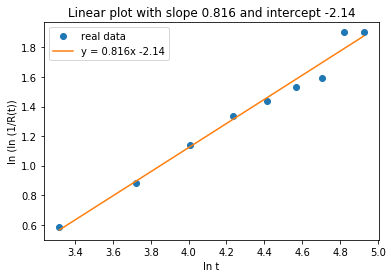

In [24]:
from probdist import _determine_exp_or_weibull, durations_to_hist
normhist, c_reliable = durations_to_hist(runtime)
value1, value2, dist = _determine_exp_or_weibull(normhist, c_reliable)

In [25]:
dist

'weibull'

### Sample MTBF

In [26]:
len(runtime[obs_run == True])

817

In [27]:
MTBF_pract = runtime[obs_run == True].mean()
MTBF_pract

12.618687610499116

In [28]:
# def exp_function(lamb, duration):
#     value = len(duration) * np.log(lamb) - lamb * np.sum(duration)
#     print('S', value)
#     return value

# def d_exp_function(lamb, duration):
#     n = len(duration)
#     print(n/lamb - np.sum(duration))
#     return n/lamb - np.sum(duration)

## Suppose exponential

In [29]:
# Plot probability
# From book Reliability engineering (A. Bilolini):
# If the item has a value lambda which is time-invariant
# lambda: failure rate during the useful life
# R(t) = 1-F(t) = exp(-lambda * t) # cumulative reliability density function
# F(t) = 1 - exp(-lambda * t) # cumulative failure density function
# Consider lambda time-independent first
# MTBF (Mean Time Between Failures) = 1/lambda
# lambda can also be found as the statistical estimate MTBF = T / k = 1 / lambda
# so lambda = k / T

In [30]:
if dist == 'exp':
    # Import home-made library
    from probdist import Exponential
    # Example scipy library
    #exp = Exponential.from_durations(runtime)
    #print(exp)
    # Example scipy library
    #exp = Exponential.from_durations2(runtime)
    #print(exp)
    from lifelines import ExponentialFitter
    exf = ExponentialFitter()
    exf.fit(runtime, cens_run)
    print(exf.lambda_)
    exp = Exponential(1/exf.lambda_)

In [31]:
if dist == 'exp':
    # Theoretical Mean Time Between Failures
    print('MTBF:', exp.mean_time())

In [32]:
if dist == 'exp':
    #Filter the duration
    maxt = np.percentile(np.array(runtime), cutoff_perc)
    mint = 0
    #duration = duration[duration.between(mint, maxt)]

In [33]:
if dist == 'exp':
    # Book Reliability and Safety Engineering, suggested number of bins, page 61
    # Sturges' rule for grouping data
    numbins = int(np.round(1 + 3.3 * np.log10(len(runtime))))
    print(numbins)

In [34]:
# from scipy.stats import chi2

# p = np.array([0.95, 0.05])
# n = len(runtime)
# T = np.sum(runtime)

# lambdas = lambda_low, lambda_high = chi2.isf(p, n)/(T)
# MTBFs = 1/lambdas

In [35]:
# exps = exp_low, exp_high = Exponential(lambda_low), Exponential(lambda_high)
# exps

In [36]:
if dist == 'exp':
    from probdist import make_hist_frame
    df_hist, ran = make_hist_frame(runtime, cens_run, numbins=numbins, range=(mint, maxt), return_bins=True)
    c_fail = df_hist['FailCDF']
    p_fail = df_hist['Failures']/len(runtime)
    plt.figure(figsize=(10,5))
    x = np.linspace(0, maxt, numbins)
    plt.bar(ran[:-1] + (ran[1]-ran[0])/2, p_fail, width=ran[1]-ran[0], edgecolor='k')
    plt.bar(ran[:-1] + (ran[1]-ran[0])/2, c_fail, width=ran[1]-ran[0], alpha=0.1, edgecolor='k')
    plt.title('Failure function F(t)')
    plt.xlabel('Time between failures [hours]')

    t = np.linspace(mint, maxt + (maxt-mint)/numbins, 100)
    plt.plot(t, exp.failure_cdf(t), 'r', label= r'$\lambda$: {:.3}'.format(exp.lamb))
    ax = plt.gca()
    # ax.fill_between(t, exp_low.failure_cdf(t), exp_high.failure_cdf(t), alpha=0.3, color='r', zorder=3)
    plt.legend()
    plt.savefig('D:/temp/temp.png', dpi=300, layout='bbox_inches_tight')

In [37]:
#from scipy.stats import chisquare
#exp_list = []
#nsamples = len(duration)
#for i in range(len(hist)):
#    exprate = (exp.failure_cdf(bin_edges[i+1]) - exp.failure_cdf(bin_edges[i])) * nsamples
#    exp_list.append(exprate)
#chisquare(hist, exp_list, ddof=3)

In [38]:
# totalvariance = 0
# for i in range(len(hist)):
#     exprate = exp.failure_cdf(bin_edges[i+1]) - exp.failure_cdf(bin_edges[i])
#     realrate = normhist[i]
#     #print(exprate, realrate)
#     var = (exprate - realrate)**2
#     totalvariance += var
# totalvariance = totalvariance / len(hist)
# totalvariance

In [39]:
if dist == 'exp':
    t = np.linspace(np.min(ran), np.max(ran), 100)
    plt.subplot(2,1,1)
    plt.bar(ran[:-1] + (ran[1]-ran[0])/2, df_hist['FailPDF'] , width=ran[1]-ran[0], edgecolor='k')
    plt.plot(t, exp.failure_pdf(t), 'k')
    plt.title('Failure probability density function')
    plt.ylabel('f(t)')
    plt.subplot(2,1,2)

    plt.subplot(2,1,2)
    plt.bar(ran[:-1] + (ran[1]-ran[0])/2, df_hist['Hazard'] , width=ran[1]-ran[0], edgecolor='k')
    plt.plot(t, exp.hazard_pdf(t), 'k')
    plt.title('Hazard rate density function')
    plt.ylabel('h(t)')
    plt.tight_layout()
    #plt.savefig('test4.png', dpi=300, layout='tight')
    plt.show()

In [40]:
#def chi_squared_test(duration, model):
#    nsamples = len(duration)
#    cutoff_perc = 99
#    maxt = np.percentile(np.array(duration), cutoff_perc)
#    mint = 0
#    numbins = int(np.round(1 + 3.3 * np.log10(len(duration))))
#    hist, bin_edges = np.histogram(np.array(duration), bins=numbins, range=(mint, maxt))
#    chi_sq = 0
#    for i in range(len(hist)):
#        obs = hist[i]
#        exp = (model.failure_cdf(bin_edges[i+1]) - model.failure_cdf(bin_edges[i])) * nsamples
#        chi_sq += (obs-exp)**2 / exp
#        #print(chi_sq)
#    return chi_sq, numbins

In [41]:
#value, ddof = chi_squared_test(duration, exp)
#chi2.cdf(value, ddof)

## Suppose Weibull distribution

In [42]:
# if dist == 'weibull':
#     from probdist import Weibull
#     weib = Weibull.from_durations(runtime)
#     #alpha, beta = determine_weibull(bin_edges[1:], 1-c_fail)
#     print(weib)

In [43]:
# from probdist import Weibull
# weib = Weibull.from_durations2(runtime)
# #alpha, beta = determine_weibull(bin_edges[1:], 1-c_fail)
# weib

In [44]:
if dist == 'weibull':
    from lifelines import WeibullFitter
    from probdist import Weibull
    wf = WeibullFitter()
    wf.fit(runtime, obs_run)
    print(wf.lambda_, wf.rho_)
    weib = Weibull(wf.lambda_, wf.rho_)

6.528174396573895 0.4812908415933308


In [45]:
wf.median_
weib.median()

3.0483689280643755

In [46]:
print('Practice:', MTBF_pract)

Practice: 12.618687610499116


In [47]:
from scipy.special import gamma
MTBF = weib.mean_time()
#MTBF = weib.alpha * gamma(1/weib.beta + 1)
print('Theory:', MTBF) # from model

Theory: 14.04404903162521


In [48]:
# from scipy.stats import norm
# vals = norm.ppf([0.95, 0.05])
# print(vals)
# beta = weib.beta
# theta = weib.alpha
# n = len(duration)
# betas = beta_low, beta_high = beta*np.exp(-0.78*vals/np.sqrt(n))
# print(betas)
# alphas = alpha_low, alpha_high = theta*np.exp(-1.05*vals/beta/np.sqrt(n))
# print(alphas)

In [49]:
# weibs = weib_low, weib_high = Weibull(alpha_low, beta_high), Weibull(alpha_high, beta_low)
# weibs

In [50]:
# plt.plot(ran[1:-1], lambdas[:-1], label='real data') # = lambda * y + c
# #plt.title('Linear plot with slope {:.3} and intercept {:.3}'.format(slope, intercept))
# #plt.plot(ran[1:-1], slope * ran[1:-1] + intercept, label='y = {:.3}x + {:.3}'.format(slope, intercept))
# plt.legend()

In [51]:
# min_mse = np.inf
# chosen_lambd = np.nan
# for lambd in lambdas:
#     mse = 0
#     for t, i in zip(bin_edges, range(len(c_fail))):
#         # theory
#         pred = p_fail(t, lambd)
#         # practice
#         data = c_fail[i]
#         mse += (pred - data) ** 2
#     if mse < min_mse:
#         #print(mse, '\t choose', lambd)
#         chosen_lambd = lambd
#         min_mse = mse
# print(chosen_lambd)

[]

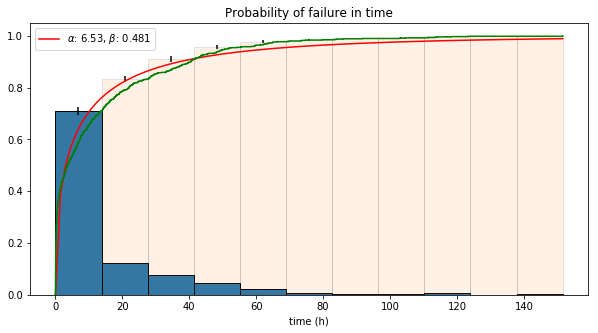

In [52]:
# alpha ~ MTBF only if beta close to 1
from probdist import make_hist_frame, sturges_rule

numbins = sturges_rule(len(runtime))

maxt = np.percentile(np.array(runtime), cutoff_perc)
mint = 0

df_hist, ran = make_hist_frame(runtime, obs_run, numbins=numbins, range=(mint, maxt), return_bins=True)
t = np.linspace(np.min(ran), np.max(ran), 100)
plt.figure(figsize=(10,5))
x = np.linspace(0, maxt, numbins)
c_fail = df_hist['FailCDF']
p_fail = df_hist['Failures']/len(runtime)
plt.bar(ran[:-1] + (ran[1]-ran[0])/2, p_fail, width=ran[1]-ran[0], edgecolor='k')
plt.bar(ran[:-1] + (ran[1]-ran[0])/2, c_fail, width=ran[1]-ran[0], alpha=0.1, edgecolor='k', yerr=df_hist['Std']**(0.5))
plt.title('Probability of failure in time')
plt.xlabel(r'time (h)')
plt.plot(t , weib.failure_cdf(t), 'r', label= r'$\alpha$: {:.3}, $\beta$: {:.3}'.format(weib.alpha, weib.beta))
ax = plt.gca()
#ax.fill_between(t, weib_low.failure_cdf(t), weib_high.failure_cdf(t), alpha=0.3, color='r', zorder=3)
kmf.fit(runtime, event_observed=obs_run)
plt.plot(1-kmf.survival_function_, color='g', drawstyle=('steps-post'))
plt.legend()
#plt.savefig('test2.png', dpi=300, layout='tight')
plt.plot()

In [53]:
##value, ddof = chi_squared_test(duration, weib)
#from scipy.signal import chi2
#chi2.cdf(value, ddof)

In [54]:
#print(value, ddof)

In [55]:
# totalvariance = 0
# for i in range(len(hist)):
#     exprate = weib.failure_cdf(bin_edges[i+1]) - weib.failure_cdf(bin_edges[i])
#     realrate = normhist[i]
#     #print(exprate, realrate)
#     var = (exprate - realrate)**2
#     totalvariance += var
# totalvariance = totalvariance / len(hist)
# totalvariance

C:\Users\jdavid\Anaconda3\lib\site-packages\matplotlib\cbook\deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


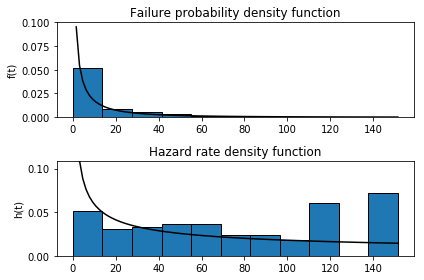

In [56]:
t = np.linspace(np.min(ran), np.max(ran), 100)
plt.subplot(2,1,1)
plt.bar(ran[:-1] + (ran[1]-ran[0])/2, df_hist['FailPDF'] , width=ran[1]-ran[0], edgecolor='k')
plt.plot(t, weib.failure_pdf(t), 'k')
plt.title('Failure probability density function')
plt.ylabel('f(t)')
plt.subplot(2,1,2)

plt.subplot(2,1,2)
plt.bar(ran[:-1] + (ran[1]-ran[0])/2, df_hist['Hazard'] , width=ran[1]-ran[0], edgecolor='k')
plt.plot(t, weib.hazard_pdf(t), 'k')
plt.title('Hazard rate density function')
plt.ylabel('h(t)')
plt.tight_layout()
#plt.savefig('text5.png', dpi=300, bbox_inches='tight')
plt.ylim(top=df_hist['Hazard'].max()*1.5)
plt.show()

In [57]:
# bin_plot = bin_edges
# x = np.linspace(0, maxt, numbins)
# plt.bar(x+(x[1]-x[0])/2, (hist) / remaining / (ran[1] - ran[0]), width=x[1]-x[0], edgecolor='k')
# plt.title('Hazard  rate function H(t)')
# plt.ylabel('h(t)')
# y = [weibull_hazard(val, alpha, beta) for val in bin_plot]
# plt.plot(bin_plot , y, 'r', label= r'\alpha: {:.3}, \beta: {:.3}'.format(alpha, beta))

In [58]:
# #Chance of failure in the first t hours after defect?
# t_wanted = 1

# #Practice:
# #totalfail = len(runtime)
# #total_select = len(runtime[runtime.between(0, t_wanted)])

# P = total_select/totalfail
# print('Real data:', P)
# # Theory:
# P = weib.failure_cdf(t_wanted)
# print('Simulated data (Weibull):', P)

# P = exp.failure_cdf(t_wanted)
# print('Simulated data (Exponential):', P)

In [59]:
# #Example: Chance of failure between tmin hours and tmax hours?
# tmin = 20
# tmax = 40

# #Practice:
# totalfail = len(duration)
# total_select = len(duration[duration.between(tmin, tmax)])

# P = total_select/totalfail
# print('Real data:', P)
# # Theory:
# P = weib.failure_cdf(tmax) - weib.failure_cdf(tmin)
# print('Simulated data (Weibull):', P)

# P = exp.failure_cdf(tmax) - exp.failure_cdf(tmin)
# print('Simulated data (Exponential):', P)

## Mean time to repair (suppose exponential)

In [60]:
# from probdist import duration_of_downtime
# downtimes = (df.Type == 'DownTime') & (df.ReasonId.isin(reasons_considered))
# dtduration = duration_of_downtime(list(df.Duration / 3600), list(downtimes))
len(downtime)

817

In [61]:
#Filter the duration
# dtmaxt = np.percentile(np.array(downtime), dtcutoff_perc)
# dtmint = 0
# downtime = downtime[downtime.between(mint, maxt)]

In [62]:
# # mean hourly failure rate (exponential)
# MLE = len(dtduration)/np.sum(dtduration)
# lambd = MLE
# print('Lambda:', lambd)
# #Mean time of a repair
# MTR = np.sum(dtduration)/len(dtduration)
# print('Mean time to repair: {:.3} hours'.format(MTR))

In [63]:
#dtduration.apply(np.log)

In [64]:
# Mean time to repair (reality)
MTTR_pract = np.mean(downtime)
print('Mean Time (practical):', MTTR_pract)

Mean Time (practical): 0.6701931184550526


## Suppose lognormal

In [65]:
from probdist import Lognormal
# logn = Lognormal.from_durations(dtduration)
# logn
from lifelines import LogNormalFitter
lnf = LogNormalFitter()
lnf.fit(downtime, obs_down)
logn = Lognormal(lnf.sigma_, lnf.mu_)
logn

Lognormal: sigma 1.3110114605794305, mu -1.8274089111269942

In [66]:
#http://reliawiki.org/index.php/The_Lognormal_Distribution
#from scipy.stats import lognorm
#param = lognorm.fit(dtduration, floc=0)
#param
#sigma = param[0]
#mu = np.log(param[2])
#print('Sigma: {}, Mu: {}'.format(sigma, mu))
#param

In [67]:
# Mean time to repair (model)
#MTTR = np.exp(logn.mu + 1/2 * logn.sigma**2)
MTTR = logn.mean_time()
MTTR
print('Mean Time (theoretical):', MTTR)

Mean Time (theoretical): 0.37982928156749496


In [68]:
downtime.max()

38.98777777777778

[]

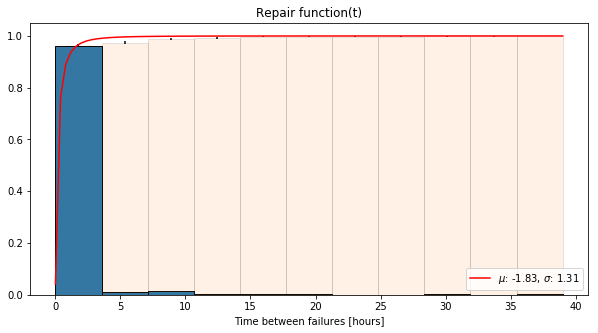

In [69]:
dt_hist, dtran = make_hist_frame(downtime, obs_down, numbins=numbins, range=(downtime.min(), downtime.max()), return_bins=True)
dtnormhist = dt_hist['Failures']/len(downtime)
dtc_fail = dt_hist['FailCDF']
plt.figure(figsize=(10,5))
wdt = dtran[1]-dtran[0]
plt.bar(dtran[:-1]+wdt/2, dtnormhist, width=wdt, edgecolor='k')
plt.bar(dtran[:-1]+wdt/2, dtc_fail, width=wdt, alpha=0.1, edgecolor='k', yerr=dt_hist['Std']**(0.5))
dtt = np.linspace(downtime.min(), downtime.max(), 100)
plt.plot(dtt, logn.failure_cdf(dtt), 'r', label= r'$\mu$: {:.3}, $\sigma$: {:.3}'.format(logn.mu, logn.sigma))
plt.title(r"Repair function(t)")
plt.xlabel('Time between failures [hours]')
plt.legend()
#plt.savefig('temp3.png', dpi=300, layout='tight')
plt.plot()

In [70]:
# totalvariance = 0
# for i in range(len(hist)):
#     exprate = logn.failure_cdf(bin_edges[i+1]) - logn.failure_cdf(bin_edges[i])
#     realrate = normhist[i]
#     #print(exprate, realrate)
#     var = (exprate - realrate)**2
#     totalvariance += var
# totalvariance = totalvariance / len(hist)
# totalvariance

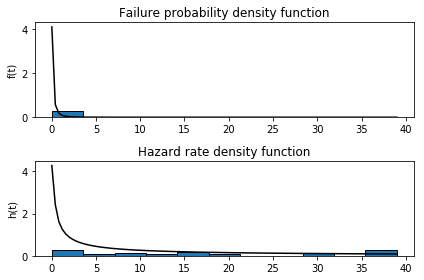

In [71]:
plt.subplot(2,1,1)
plt.bar(dtran[:-1]+wdt/2, dt_hist['FailPDF'] , width=wdt, edgecolor='k')
plt.plot(dtt , logn.failure_pdf(dtt), 'k')
plt.title('Failure probability density function')
plt.ylabel('f(t)')

plt.subplot(2,1,2)
plt.bar(dtran[:-1]+wdt/2, dt_hist['Hazard'] , width=wdt, edgecolor='k')

plt.plot(dtt , logn.hazard_pdf(dtt), 'k')
plt.title('Hazard rate density function')
plt.ylabel('h(t)')
plt.tight_layout()
#plt.savefig('temp6.png', dpi=300, bbox_inches='tight')
plt.show()

In [72]:
#value, ddof = chi_squared_test(dtduration, logn)
#chi2.cdf(value, ddof)
#print(value, ddof)

In [73]:
#from scipy.stats import chisquare
#dtexp_list = []
#nsamples = len(dtduration)
#for i in range(len(dthist)):
#    exprate = (logn.failure_cdf(dtbin_edges[i+1]) - logn.failure_cdf(dtbin_edges[i])) * nsamples
#    dtexp_list.append(exprate)
##print(exp_list)
##print(hist)
#chisquare(dthist, dtexp_list, ddof=1)

# Modeling a failure (Monte Carlo simulation)

In [74]:
if dist == 'exp':
    print(exp.generate_failure_time())

In [75]:
if dist == 'weibull':
    print(weib.generate_failure_time())

6.869726542351361


In [76]:
logn.generate_failure_time()

0.1720687388739128

## Availability

In [77]:
MTBF = weib.mean_time() # mean time to failure
MTTR = logn.mean_time() # mean time to repair
print('MTBF:', MTBF, 'MTTR:', MTTR)

MTBF: 14.04404903162521 MTTR: 0.37982928156749496


In [78]:
MTBF/(MTTR + MTBF) # inherent availability

0.9736666329734571

In [79]:
# #Practical availability
MTBF_pract / (MTTR_pract + MTBF_pract)

0.9495673765063736

In [80]:
# Other way to calculate this
#np.sum(duration)/ (np.sum(dtduration)+ np.sum(duration))

In [81]:
import scipy.integrate as integrate
integrate.quad(weib.reliability_cdf, 0, 5)[0]

2.8215098127457514

Optimization terminated successfully.
         Current function value: 13.614010
         Iterations: 32
         Function evaluations: 64
Time between planned maintenance: 136 hours = less then 6 days


(-1.3868149568148134, 20.802224352222197)

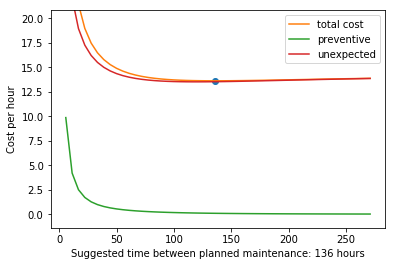

In [82]:
from probdist import total_cost_maintenance, pm_recommend
import scipy
cp = 100
cu = 200


minimum = pm_recommend(weib, cp, cu)
PM = int(np.ceil(minimum))
print('Time between planned maintenance:', PM, 'hours = less then', int(np.ceil(PM / 24)), 'days')
plt.plot(minimum, total_cost_maintenance(minimum, weib, cp, cu), 'o')
t_plot = np.linspace(0, minimum * 2, 50)
total, prev, unexp = total_cost_maintenance(t_plot, weib, cp, cu, True)
plt.plot(t_plot, total, label='total cost')
plt.plot(t_plot, prev, label='preventive')
plt.plot(t_plot, unexp, label='unexpected')
plt.legend()
plt.ylabel('Cost per hour')
plt.xlabel(f'Suggested time between planned maintenance: {PM} hours')
plt.ylim(bottom=-total[-1]*0.1, top=total[-1]*1.5)
#plt.xlim(left=0, right= minimum * 2 + 10)

In [83]:
### Generate data for usage in Model from Ke
PM = int(np.ceil(pm_recommend(weib, cp, cu)))
print('Preventive Maintenance recommended every {:} hours'.format(PM))
t_temp = np.arange(0, np.ceil(PM)+1, 1)
hourly_failure_rate = np.array([weib.failure_cdf(te) - weib.failure_cdf(ts) for ts, te in zip(t_temp[:-1], t_temp[1:])])
print('Hourly failure rate: \n{}'.format(np.array2string(hourly_failure_rate, precision=3)))
pd.DataFrame(hourly_failure_rate).to_csv('hourlyfailurerate.csv', index=False, header=['Influence'])
sum(hourly_failure_rate)

Optimization terminated successfully.
         Current function value: 13.614010
         Iterations: 32
         Function evaluations: 64
Preventive Maintenance recommended every 136 hours
Hourly failure rate: 
[3.333e-01 9.888e-02 6.519e-02 4.881e-02 3.888e-02 3.216e-02 2.729e-02
 2.359e-02 2.068e-02 1.833e-02 1.641e-02 1.479e-02 1.342e-02 1.225e-02
 1.123e-02 1.034e-02 9.557e-03 8.863e-03 8.244e-03 7.689e-03 7.189e-03
 6.737e-03 6.326e-03 5.952e-03 5.610e-03 5.297e-03 5.009e-03 4.743e-03
 4.497e-03 4.270e-03 4.058e-03 3.862e-03 3.679e-03 3.508e-03 3.349e-03
 3.199e-03 3.059e-03 2.927e-03 2.803e-03 2.687e-03 2.577e-03 2.473e-03
 2.375e-03 2.282e-03 2.195e-03 2.112e-03 2.033e-03 1.958e-03 1.887e-03
 1.819e-03 1.755e-03 1.693e-03 1.635e-03 1.579e-03 1.526e-03 1.475e-03
 1.427e-03 1.380e-03 1.336e-03 1.294e-03 1.253e-03 1.214e-03 1.176e-03
 1.141e-03 1.106e-03 1.073e-03 1.041e-03 1.011e-03 9.813e-04 9.531e-04
 9.259e-04 8.997e-04 8.745e-04 8.502e-04 8.268e-04 8.042e-04 7.824e-04
 7.614e

0.9865962426350225

## Export all necessary info to XML

In [84]:
import xml.etree.ElementTree as ET
root = ET.Element("failure-info")
files = ET.SubElement(root, "files")
inputfile = ET.SubElement(files, "inputfile")
inputfile.text = filename
fail_dist = ET.SubElement(root, "fail_dist")
fail_dist.text = dist
if dist == "weibull":
    fail_dist.set("lambda", str(wf.lambda_))
    fail_dist.set("rho", str(wf.rho_))
elif dist == "exp":
    fail_dist.set("expo", str(exp.lambda_))
else:
    raise NameError("No distribuion found")
repair_dist = ET.SubElement(root, "repair_dist")
repair_dist.text = "lognormal"
repair_dist.set("sigma", str(lnf.sigma_))
repair_dist.set("mu", str(lnf.mu_))
repair_dist.set("mean", str(MTTR_pract))
maint_time = ET.SubElement(root, "maintenance_time")
maint_time.text = str(PM)
repair_time = ET.SubElement(root, "repair_time")
repair_time.text = str(PM/50)
tree = ET.ElementTree(root)
tree.write(filename.split('.')[0] + "_outputfile.xml")

In [85]:
PM

136